In [1]:
# Import libraries
import pandas as pd
import numpy as np
import json
import re
import spacy
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
nltk.download('stopwords')
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
zf = zipfile.ZipFile('tripadvisor_hotel_reviews.zip') 
df = pd.read_csv(zf.open('tripadvisor_hotel_reviews.csv'))

In [4]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 7.6 MB 37.8 MB/s 
     |████████████████████████████████| 182 kB 43.5 MB/s 


In [6]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Flatten,Dropout,Embedding
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [8]:
def unique_words(word,rating=None):
    words=[]
    stopwords=set(STOPWORDS)
    some_more_common_words=set(['hotel','room','service','rooms','stayed','just','no','not','staff'])
    stopwords.update(some_more_common_words)
    copy=df['Review']
    if rating!=None:
        copy=df[df['Rating']==rating]['Review']
    for y in copy:
        s=y.split(" ")
        for x in s:
            if x.isalpha() and x not in stopwords:
                words.append(x)
    return np.array(Counter(words).most_common(word))

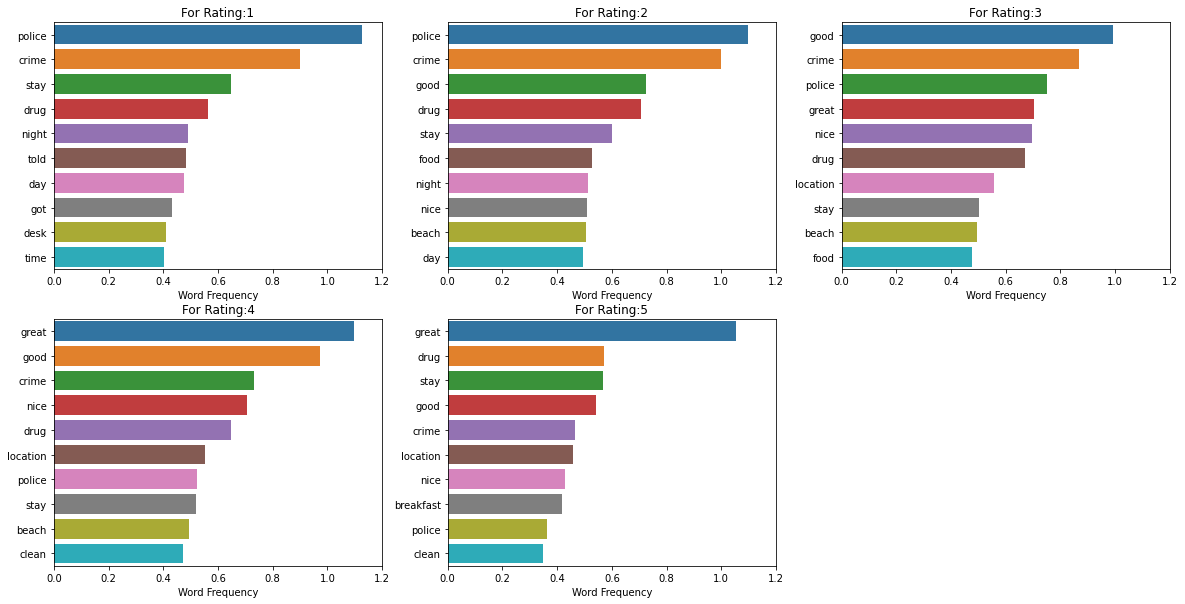

In [9]:
fig=plt.figure(figsize=(20,10))
counts=Counter(df['Rating'])
for rating in range(1,6):
    rated=unique_words(word=10,rating=rating)
    plt.subplot(2,3,rating)
    plt.xlabel('Word Frequency')
    plt.xlim([0,1.2])
    plt.title('For Rating:'+ str(rating))
    sns.barplot(y=rated[:,0],x=rated[:,1].astype(int)/counts[rating])
plt.show()

In [10]:
s=set()
stop=set(STOPWORDS)
lemma=WordNetLemmatizer()
for x in df['Review']:
    x=re.sub('[^A-Za-z]'," ",x)
    x=x.split(" ")
    for w in x:
        w=lemma.lemmatize(w)
        if w not in stop:
            s.add(w)
len(s)#number of distinct words

44740

In [11]:
def lemmatizer(x):
    x=re.sub('[^A-Za-z]',' ',x)
    s=x.split(" ")
    h=[]
    for y in s:
        y=lemma.lemmatize(y)
        if y not in stop:
            h.append(y)
    return " ".join(h)  

In [12]:
df['nlp_text']=df['Review'].apply(lambda x: lemmatizer(x))

In [13]:
df.head()

,Review,Rating,nlp_text
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle g...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monac...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game aweso...


In [14]:
num_words=20000
tokenizer=Tokenizer(num_words=num_words,oov_token='OOV')
tokenizer.fit_on_texts(df['nlp_text'])
tokenized_text=tokenizer.texts_to_sequences(df['nlp_text'])
np.mean([len(x) for x in tokenized_text])

101.7221707090918

In [15]:
length=100
tokenized_text=pad_sequences(tokenized_text,length,padding='post',truncating='post')
output=to_categorical(df['Rating'])
output=output[:,1:]

In [16]:
train,test,y_train,y_test=train_test_split(tokenized_text,output,test_size=0.2,random_state=21)

In [17]:
vector_space=32
model=Sequential()
model.add(Embedding(num_words,vector_space,input_length=length))
model.add(LSTM(16,return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(16,return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(32))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           640000    
                                                                 
 lstm (LSTM)                 (None, 100, 16)           3136      
                                                                 
 lstm_1 (LSTM)               (None, 100, 16)           2112      
                                                                 
 lstm_2 (LSTM)               (None, 32)                6272      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2

In [19]:
epoch=20
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train,y_train,validation_split=0.2,epochs=epoch,batch_size=1000)

Epoch 1/20
14/14 [==============================] - 23s 1s/step - loss: 1.5398 - accuracy: 0.4182 - val_loss: 1.3786 - val_accuracy: 0.4440
Epoch 2/20
14/14 [==============================] - 13s 907ms/step - loss: 1.3808 - accuracy: 0.4345 - val_loss: 1.3687 - val_accuracy: 0.4440
Epoch 3/20
14/14 [==============================] - 15s 1s/step - loss: 1.3594 - accuracy: 0.4316 - val_loss: 1.3366 - val_accuracy: 0.4440
Epoch 4/20
14/14 [==============================] - 13s 899ms/step - loss: 1.3331 - accuracy: 0.4393 - val_loss: 1.2903 - val_accuracy: 0.4440
Epoch 5/20
14/14 [==============================] - 13s 900ms/step - loss: 1.2020 - accuracy: 0.4378 - val_loss: 1.1190 - val_accuracy: 0.4657
Epoch 6/20
14/14 [==============================] - 13s 900ms/step - loss: 1.0978 - accuracy: 0.4685 - val_loss: 1.0817 - val_accuracy: 0.4971
Epoch 7/20
14/14 [==============================] - 13s 895ms/step - loss: 1.0399 - accuracy: 0.5093 - val_loss: 1.0563 - val_accuracy: 0.4977
Epoch

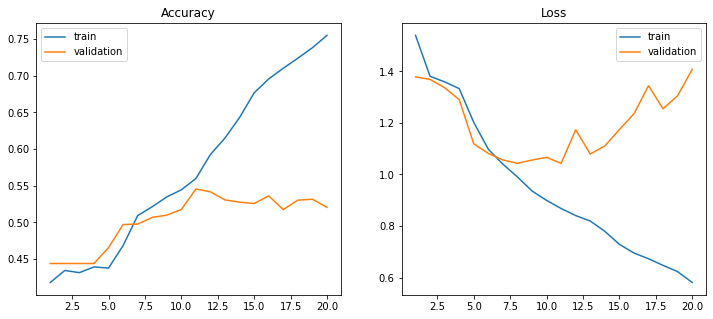

In [20]:
h=history.history
fig=plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(range(1,epoch+1),h['accuracy'],label='train')
plt.plot(range(1,epoch+1),h['val_accuracy'],label='validation')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(range(1,epoch+1),h['loss'],label='train')
plt.plot(range(1,epoch+1),h['val_loss'],label='validation')
plt.legend()
plt.show()

In [21]:
train,test,y_train,y_test=train_test_split(tokenized_text,df['Rating'],test_size=0.2,random_state=21)

In [22]:
model=Sequential()
model.add(Embedding(num_words,vector_space,input_length=length))
model.add(LSTM(32))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='relu'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           640000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 256)               8448      
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 657,025
Trainable params: 657,025
Non-trainable params: 0
_________________________________________________________________


In [24]:
epoch=20
model.compile(optimizer='Adam',loss='mse',metrics='mae')
history=model.fit(train,y_train,epochs=epoch,batch_size=250,validation_split=0.2)

Epoch 1/20
53/53 [==============================] - 10s 136ms/step - loss: 6.8142 - mae: 2.1003 - val_loss: 1.4909 - val_mae: 0.9418
Epoch 2/20
53/53 [==============================] - 8s 153ms/step - loss: 1.4865 - mae: 0.9594 - val_loss: 1.4356 - val_mae: 0.9511
Epoch 3/20
53/53 [==============================] - 6s 123ms/step - loss: 1.4367 - mae: 0.9461 - val_loss: 1.4047 - val_mae: 0.9440
Epoch 4/20
53/53 [==============================] - 7s 124ms/step - loss: 1.3403 - mae: 0.9101 - val_loss: 1.3083 - val_mae: 0.9053
Epoch 5/20
53/53 [==============================] - 7s 135ms/step - loss: 1.1347 - mae: 0.8175 - val_loss: 1.1292 - val_mae: 0.8264
Epoch 6/20
53/53 [==============================] - 7s 125ms/step - loss: 0.6954 - mae: 0.6543 - val_loss: 0.6769 - val_mae: 0.6654
Epoch 7/20
53/53 [==============================] - 7s 124ms/step - loss: 0.4537 - mae: 0.5364 - val_loss: 0.6682 - val_mae: 0.6457
Epoch 8/20
53/53 [==============================] - 7s 124ms/step - loss: 0

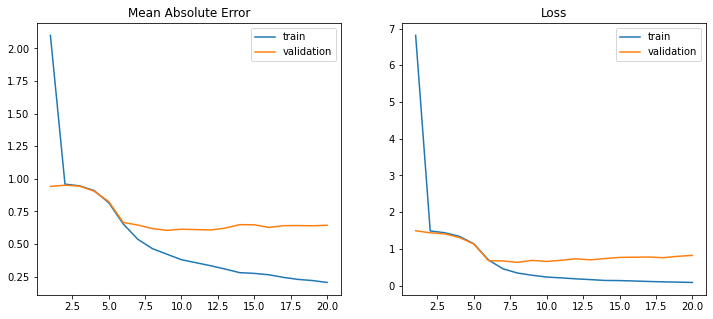

In [25]:
h=history.history
fig=plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Mean Absolute Error')
plt.plot(range(1,epoch+1),h['mae'],label='train')
plt.plot(range(1,epoch+1),h['val_mae'],label='validation')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(range(1,epoch+1),h['loss'],label='train')
plt.plot(range(1,epoch+1),h['val_loss'],label='validation')
plt.legend()
plt.show()

In [26]:
def get_preds(data,true_labels):
    pred=model.predict(data)
    h=[]
    for x in pred:
        if x-int(x)>=0.5:
            h.append(np.ceil(x))
        else :
            h.append(np.floor(x))
    print(pred[0:5])
    print(true_labels[:5])
    return accuracy_score(h,true_labels)

In [27]:
get_preds(train,y_train)

513/513 [==============================] - 7s 12ms/step
[[4.246996]
 [4.807761]
 [2.067995]
 [3.99785 ]
 [4.11705 ]]
10294    4
11753    5
16362    2
7074     4
14058    4
Name: Rating, dtype: int64


0.849194729136164

In [28]:
get_preds(test,y_test)

129/129 [==============================] - 2s 16ms/step
[[3.9417994]
 [4.030727 ]
 [5.0107613]
 [4.645547 ]
 [4.454839 ]]
955      3
19500    5
19157    5
17671    5
17723    5
Name: Rating, dtype: int64


0.5186630885581849